# Reproducing McNally's paper

https://bitbucket.org/colinmcnally/rbfmhd/src/master/rbfvmod.py

http://colinmcnally.ca/dfi/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from time import sleep

#the accompanying RBF-FD class
from turboflow.models.mcnally import rbf_vector_divfree

In [47]:
# Colin P. McNally 2010,2011,2019
matplotlib.rcParams['axes.formatter.limits'] = (-2,2)


boxlen = 1.0  #size of the 2d box
nx = 16       #number of grid points in each direction
dx = boxlen/(nx)

cs = 1.0   #isothermal sound speed
nu  = 0.001 #viscosity
eta = 0.001 #resistivity
cfl = 0.2   #CFL factor

#initialize the stencils
snx = 2 #stencil size 5 or 3
rbfepsilon = 1./64. # the episilon scale factor for the Gaussian RBF
myrbf = rbf_vector_divfree(snx,eps_override=rbfepsilon)
###

[[0.03076457 0.         0.         0.        ]
 [0.         0.03076457 0.         0.        ]
 [0.         0.         0.03076457 0.        ]
 [0.         0.         0.         0.03076457]]
[[ 0.00024224  0.          0.          0.        ]
 [ 0.         -0.00024224  0.          0.        ]
 [ 0.          0.         -0.00024224  0.        ]
 [ 0.          0.          0.          0.00024224]]
[[0.03076457 0.         0.         0.        ]
 [0.         0.03076457 0.         0.        ]
 [0.         0.         0.03076457 0.        ]
 [0.         0.         0.         0.03076457]]


ZeroDivisionError: division by zero

In [39]:
cs2 = cs**2

nd = nx*nx

#utility for handing periodic BCs
def wrap(val):
    if (val>=nx):
        val = val-nx
    elif (val<0):
        val = nx+val
    return val

#to hack in outflow BCs
def outflowbc(rho):
    rho[:,0] = rho[:,1]
    rho[:,nx-1] = rho[:,nx-2]
    rho[0,:] = rho[1,:]
    rho[nx-1,:] = rho[nx-2,:]
    return rho

#set up grids
ti = np.linspace(0.0, boxlen-dx, nx)
x, y = np.meshgrid(ti, ti)
pltti = np.linspace(0.0, boxlen, nx+1)
pltx, plty = np.meshgrid(pltti, pltti)

In [23]:
# define a subroutine using globals just to streamline redrawing the plot
def drawplot(pltx, plty, v1, v2, b1, b2, rho):
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(2, 6, width_ratios = [5,1,5,1,5,1])
    caspect = 40
    cshrink = 0.8
    p1 = plt.subplot(gs[0,0])
    c1 = plt.subplot(gs[0,1])
    p2 = plt.subplot(gs[0,2])
    c2 = plt.subplot(gs[0,3])
    p3 = plt.subplot(gs[1,0])
    c3 = plt.subplot(gs[1,1])
    p4 = plt.subplot(gs[1,2])
    c4 = plt.subplot(gs[1,3])
    p5 = plt.subplot(gs[0,4])
    c5 = plt.subplot(gs[0,5])
    p6 = plt.subplot(gs[1,4])

    cm = p1.pcolormesh(pltx,plty,v1,vmax=v1limits[0],vmin=v1limits[1])
    p1.set_title('$V_x$')
    p1.set_aspect('equal')
    plt.colorbar(cm,cax=c1)#, aspect = caspect, shrink = cshrink)

    cm = p2.pcolormesh(pltx,plty,v2,vmax=v2limits[0],vmin=v2limits[1])
    p2.set_title('$V_y$')
    p2.set_aspect('equal')
    plt.colorbar(cm,cax=c2, aspect = caspect, shrink = cshrink)

    cm = p3.pcolormesh(pltx,plty,b1,vmax=b1limits[0],vmin=b1limits[1])
    p3.set_title('$B_x$')
    p3.set_aspect('equal')
    plt.colorbar(cm,cax=c3, aspect = caspect, shrink = cshrink)

    cm = p4.pcolormesh(pltx,plty,b2,vmax=b2limits[0],vmin=b2limits[1])
    p4.set_title('$B_y$')
    p4.set_aspect('equal')
    plt.colorbar(cm,cax=c4, aspect = caspect, shrink = cshrink)

    cm = p5.pcolormesh(pltx,plty,np.log10(rho),vmax=np.log10(rholimits[0]),vmin=np.log10(rholimits[1]))
    p5.set_title(r'$\log(\rho)$')
    p5.set_aspect('equal')
    plt.colorbar(cm,cax=c5, aspect = caspect, shrink = cshrink)

    q2 = p6.quiver(x,y,b1,b2,0*rho,width=0.004)
    p6.set_aspect('equal')
    p6.set_title('$B$')
    plt.show()
    return

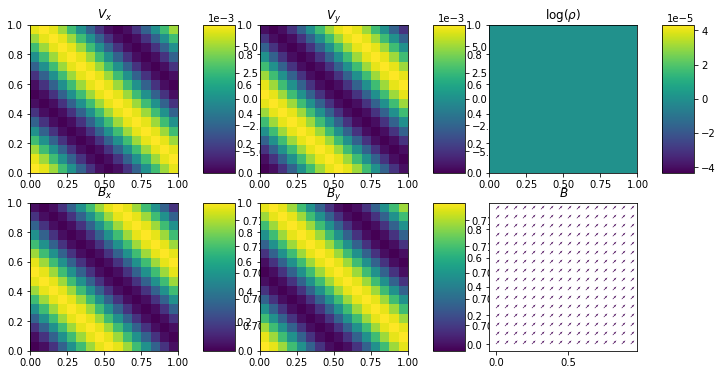

In [24]:
#fields for the simulation
rho = np.ones([nx,nx])
b1 = np.zeros([nx,nx])
b2 = np.zeros([nx,nx])
u1 = np.zeros([nx,nx])
u2 = np.zeros([nx,nx])
v1 = np.zeros([nx,nx])
v2 = np.zeros([nx,nx])

#a big pile of arrays to hold all the possible derivatives
rhox  = np.zeros([nx,nx])
rhoy  = np.zeros([nx,nx])
rhoxx = np.zeros([nx,nx])
rhoxy = np.zeros([nx,nx])
rhoyy = np.zeros([nx,nx])
b1x  = np.zeros([nx,nx])
b1y  = np.zeros([nx,nx])
b1xx = np.zeros([nx,nx])
b1xy = np.zeros([nx,nx])
b1yy = np.zeros([nx,nx])
b2x  = np.zeros([nx,nx])
b2y  = np.zeros([nx,nx])
b2xx = np.zeros([nx,nx])
b2xy = np.zeros([nx,nx])
b2yy = np.zeros([nx,nx])
u1x  = np.zeros([nx,nx])
u1y  = np.zeros([nx,nx])
u1xx = np.zeros([nx,nx])
u1xy = np.zeros([nx,nx])
u1yy = np.zeros([nx,nx])
u2x  = np.zeros([nx,nx])
u2y  = np.zeros([nx,nx])
u2xx = np.zeros([nx,nx])
u2xy = np.zeros([nx,nx])
u2yy = np.zeros([nx,nx])
v1x  = np.zeros([nx,nx])
v1y  = np.zeros([nx,nx])
v1xx = np.zeros([nx,nx])
v1xy = np.zeros([nx,nx])
v1yy = np.zeros([nx,nx])
v2x  = np.zeros([nx,nx])
v2y  = np.zeros([nx,nx])
v2xx = np.zeros([nx,nx])
v2xy = np.zeros([nx,nx])
v2yy = np.zeros([nx,nx])

#arrays for the time derivatives of each field
rhotnow = np.zeros([nx,nx])
u1tnow = np.zeros([nx,nx])
u2tnow = np.zeros([nx,nx])
b1tnow = np.zeros([nx,nx])
b2tnow = np.zeros([nx,nx])

#alfven wave 
bparallel = 1.0
bperp = 1e-2

#along the diagonal
angle = -1*np.pi/4
wavelength =  np.sqrt(2.0)/2
#along the y axis
#angle = -np.pi/2
#wavelength = 1.0

t_total = 1.0*wavelength #total time of simulation

xwave = x*np.cos(angle) - y*np.sin(angle)
ywave = x*np.sin(angle) + y*np.cos(angle)
#magnetic field
b1 = bparallel*np.cos(-angle) + np.sin(angle)*bperp*np.cos(2*np.pi*xwave/wavelength)
b2 = bparallel*np.sin(-angle) + np.cos(angle)*bperp*np.cos(2*np.pi*xwave/wavelength)
#momentum
u1 = np.sin(angle)*bperp*-np.cos(2*np.pi*xwave/wavelength)*np.sqrt(rho)
u2 = np.cos(angle)*bperp*-np.cos(2*np.pi*xwave/wavelength)*np.sqrt(rho)

#initialize veocity from momentum and density
v1 = u1/rho
v2 = u2/rho

v1limits = (v1.max(),v1.min())
v2limits = (v2.max(),v2.min())
#alfven wave 
rholimits = (rho.max(),rho.min())
b1limits = (b1.max(),b1.min())
b2limits = (b2.max(),b2.min())

#alfven wave 
rholimits = (1.0-1e-4, 1.0+1e-4)

#need to build small arrays for taking derivatives with
sw = snx//2
srho = np.zeros([snx,snx])
sb1 = np.zeros([snx,snx])
sb2 = np.zeros([snx,snx])
sv1 = np.zeros([snx,snx])
sv2 = np.zeros([snx,snx])
su1 = np.zeros([snx,snx])
su2 = np.zeros([snx,snx])

drawplot(pltx, plty, v1, v2, b1, b2, rho)

In [32]:
for i in range(0,nx):
    for j in range(0,nx):
        il = i-sw
        jl = j-sw
        for k in range(0,snx):
            for l in range(0,snx):
                srho[k,l] = rho[wrap(il+k),wrap(jl+l)] # implemented periodicity of the field
                sv1[k,l]  = v1[wrap(il+k),wrap(jl+l)]
                sv2[k,l]  = v2[wrap(il+k),wrap(jl+l)]
                su1[k,l]  = u1[wrap(il+k),wrap(jl+l)]
                su2[k,l]  = u2[wrap(il+k),wrap(jl+l)]
                sb1[k,l]  = b1[wrap(il+k),wrap(jl+l)]
                sb2[k,l]  = b2[wrap(il+k),wrap(jl+l)]

        #this set of calls calculates the derivatives
        [srhox,srhoy,srhoxx,srhoxy,srhoyy] = myrbf.scalarderivs(srho,dx)
        [sv1x,sv1y,sv1xx,sv1xy,sv1yy] = myrbf.scalarderivs(sv1,dx)
        [sv2x,sv2y,sv2xx,sv2xy,sv2yy] = myrbf.scalarderivs(sv2,dx)
        [su1x,su1y,su1xx,su1xy,su1yy] = myrbf.scalarderivs(su1,dx)
        [su2x,su2y,su2xx,su2xy,su2yy] = myrbf.scalarderivs(su2,dx)
        [sb1x,sb1y,sb2x,sb2y,sb1xx,sb1xy,sb1yy,sb2xx,sb2xy,sb2yy] = myrbf.divfreederivs(sb1,sb2,dx)

        print(sb1)
        print(sb2)
        1/0

9
0 0
(9, 9)


ZeroDivisionError: division by zero

In [8]:

t = 0.0
dt = 0.0
dtnext = 0.0
#timestep loop
while t < t_total:
    #for each point in the grid, gather the needed points for the stencil and compute the derivatives
    for i in range(0,nx):
        for j in range(0,nx):
            il = i-sw
            jl = j-sw
            for k in range(0,snx):
                for l in range(0,snx):
                    srho[k,l] = rho[wrap(il+k),wrap(jl+l)]
                    sv1[k,l]  = v1[wrap(il+k),wrap(jl+l)]
                    sv2[k,l]  = v2[wrap(il+k),wrap(jl+l)]
                    su1[k,l]  = u1[wrap(il+k),wrap(jl+l)]
                    su2[k,l]  = u2[wrap(il+k),wrap(jl+l)]
                    sb1[k,l]  = b1[wrap(il+k),wrap(jl+l)]
                    sb2[k,l]  = b2[wrap(il+k),wrap(jl+l)]
    
            #this set of calls calculates the derivatives
            [srhox,srhoy,srhoxx,srhoxy,srhoyy] = myrbf.scalarderivs(srho,dx)
            [sv1x,sv1y,sv1xx,sv1xy,sv1yy] = myrbf.scalarderivs(sv1,dx)
            [sv2x,sv2y,sv2xx,sv2xy,sv2yy] = myrbf.scalarderivs(sv2,dx)
            [su1x,su1y,su1xx,su1xy,su1yy] = myrbf.scalarderivs(su1,dx)
            [su2x,su2y,su2xx,su2xy,su2yy] = myrbf.scalarderivs(su2,dx)
            [sb1x,sb1y,sb2x,sb2y,sb1xx,sb1xy,sb1yy,sb2xx,sb2xy,sb2yy] = myrbf.divfreederivs(sb1,sb2,dx)

            #store the results of the derivative calculations
            rhox[i,j]  = srhox
            rhoy[i,j]  = srhoy
            rhoxx[i,j] = srhoxx
            rhoxy[i,j] = srhoxy
            rhoyy[i,j] = srhoyy
            v1x[i,j]  = sv1x
            v1y[i,j]  = sv1y
            v1xx[i,j] = sv1xx
            v1xy[i,j] = sv1xy
            v1yy[i,j] = sv1yy
            v2x[i,j]  = sv2x
            v2y[i,j]  = sv2y
            v2xx[i,j] = sv2xx
            v2xy[i,j] = sv2xy
            v2yy[i,j] = sv2yy
            u1x[i,j]  = su1x
            u1y[i,j]  = su1y
            u1xx[i,j] = su1xx
            u1xy[i,j] = su1xy
            u1yy[i,j] = su1yy
            u2x[i,j]  = su2x
            u2y[i,j]  = su2y
            u2xx[i,j] = su2xx
            u2xy[i,j] = su2xy
            u2yy[i,j] = su2yy
            b1x[i,j]  = sb1x
            b1y[i,j]  = sb1y
            b1xx[i,j] = sb1xx
            b1xy[i,j] = sb1xy
            b1yy[i,j] = sb1yy
            b2x[i,j]  = sb2x
            b2y[i,j]  = sb2y
            b2xx[i,j] = sb2xx
            b2xy[i,j] = sb2xy
            b2yy[i,j] = sb2yy

    #use the MHD equations to calculate time derivatives from the spatial derivatives just calculated
    rhotnow = -(u1x + u2y)
    u1tnow = -(v1*u1x + u1*v1x + v1*u2y + u2*v1y) - cs2*rhox + nu*(u1xx+u1yy) +b1*b1x -b2*b2x +b2*b1y +b1*b2y
    u2tnow = -(v2*u2y + u2*v2y + v2*u1x + u1*v2x) - cs2*rhoy + nu*(u2xx+u2yy) +b2*b2y -b1*b1y +b1*b2x +b2*b1x
    vdiv = v1x + v2y 
    b1tnow = -b1*v2y -v2*b1y +b2*v1y +v1*b2y +eta*(b1xx+b1yy)
    b2tnow = -b2*v1x -v1*b2x +b1*v2x +v2*b1x +eta*(b2xx+b2yy)

    #calculate timestep
    dt = dtnext
    vmax = (np.sqrt(u1**2+u2**2)/rho).max()
    valfvenmax = (np.sqrt((b1**2+b2**2)/rho)).max() 
    signalmax = cs + valfvenmax + vmax  #max signal speed
    dtsignal = dx/signalmax #the Courant timestep
    dtvisc = min(dx**2/(2.0*nu),dx**2/(2.0*eta)) # Timestep for FTCS viscosity operator
    print( '  dtsignal',dtsignal,' dtvisc',dtvisc)
    dtnext = cfl*min(dtsignal,dtvisc) #take the minumum * CFL factor as the next timestep
    if (t+dt+dtnext>t_total):  #limit the timestep to not go past end time of simulation
        dtnext = t_total-t-dt
    print( 't= ',t,'  dtnext=',dtnext)

    t = t+dt #update the simulation time
    #Forward-Euler update of fields
    rho = rho + dt*(rhotnow)
    u1 = u1 + dt*(u1tnow)
    u2 = u2 + dt*(u2tnow)
    v1 = u1/rho
    v2 = u2/rho
    b1 = b1 + dt*(b1tnow)
    b2 = b2 + dt*(b2tnow)

    #These lines hack in zero-gradient BCs
#     rho = outflowbc(rho)
#     u1 = outflowbc(u1)
#     u2 = outflowbc(u2)
#     v1 = outflowbc(v1)
#     v2 = outflowbc(v2)
#     b1 = outflowbc(b1)
#     b2 = outflowbc(b2)

    #print stats here
    print( '    max mag B  ',(np.sqrt(b1**2+b2**2)).max())
    print( '    max     B1 ',(b1).max())
    print( '    max     B2 ',(b2).max())
    print( '    max mag V ',(np.sqrt(v1**2+v2**2)).max())

    #This block makes a 6-panel plot of the fields. The display calls sometimes don't work the same on 
    # other matplotlib backends. you might have to play a bit to make the plot pop up on your machine.
    drawplot(pltx, plty, v1, v2, b1, b2, rho)

#Done the run. Save the output for later.
print( 'end time ',t)
# np.savez('rbfmhd_'+str(snx)+'_'+str(nx)+'.npz',b1=b1,b2=b2,rho=rho,v1=v1,v2=v2,pltx=pltx,plty=plty)
plt.show()

ZeroDivisionError: division by zero